# Sentiment Analysis of Amazon Product Reviews

This jupyter notebook contains the code for exploratory data anlysis on amazon product reviews and training the sentiment analysis classifiers. You can open this notebook in Google colab and execute the cells, but make sure you create an `amazon_reviews` directory in your drive/MyDrive/ and copy the relevant files from [this link](https://drive.google.com/drive/folders/13MS_WA1Ad35fvlaXQ6hxhl3BlsthP61x?usp=sharing).

## Setup

In [1]:
# loading libraries

import numpy as np
import pandas as pd
import json
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import pickle

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Mounting Google colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you are running the code in Google colab, make sure you create an amazon_reviews directory in your drive/MyDrive/ and copy the relevant files from [this link](https://drive.google.com/drive/folders/13MS_WA1Ad35fvlaXQ6hxhl3BlsthP61x?usp=sharing).

In [3]:
cd drive/MyDrive/amazon_reviews

/content/drive/MyDrive/amazon_reviews


## Loading data

We selected eight product categories: Fashion, Software, Appliances, Gift Cards, Magazine Subscriptions, Prime Pantry, Luxury Beauty, All Beauty, and took at most the first 200K reviews from each category. From all product metadata, we only keep the reviewTime, reviewText, summary and overall rating, which is an integer between 1 to 5. The `category` shows the product category, which is one of the classes mentioned above.

In [4]:
max_n = 200000 # maximum number of reviews selected from each category
categories = ['Fashion', 'Software', 'Appliances', 'Gift_Cards', 'Magazine_Subscriptions', 'Prime_Pantry', 'Luxury_Beauty', 'All_Beauty']

df_all = pd.DataFrame(columns=['overall', 'reviewTime', 'reviewText', 'summary', 'category'])
for c in categories:
  df = pd.read_json('datasets/'+c+'.json', lines=True)
  df['category'] = c
  df = df[['overall', 'reviewTime', 'reviewText', 'summary', 'category']][:max_n]
  df.reviewText = df.reviewText.astype(str)
  df.summary = df.summary.astype(str)
  df_all = pd.concat([df_all, df], ignore_index=True)

In [5]:
print('Total number of reviews:', len(df_all))

Total number of reviews: 1436883


In [6]:
print('Example review:')
df_all['reviewText'][200010]

Example review:


"Maybe it's just me (I have no marketing background but desperately want to learn for my start-up) but I cannot get hardly anything out of this text. I have tried very hard to tread through the writing and learn something useful but chapter after chapter seems to be the exact same thing... overly wordy, rambling & unnecessarily academic writing with no comprehensible message behind it, no strategies I can apply to my own business and no organization that I can make sense of. Feels almost like I'm reading a paper a college student BSed their way through with a whole bunch of long words and cryptic sentences in order to sound impressive. What a rip-off. I paid $70 for this and it has been the most useless book I've paid for in my research process (and I've read 16 other books thus far to help me with my venture).\n\nThe only reason I'm giving this two stars and not one star is that out of the first six chapters I've read, two of them actually made sense. One was on International Marketin

In [7]:
print('Example summary:')
df_all['summary'][200010]

Example summary:


'This book is intolerable'

In [8]:
print('Example reviews from the Software category')
df_all[df_all['category']=='Software'].head(10)

Example reviews from the Software category


overall   reviewTime  \
200000       4  03 11, 2014   
200001       4  02 23, 2014   
200002       1  02 17, 2014   
200003       3  02 17, 2014   
200004       5  10 14, 2013   
200005       4  08 15, 2011   
200006       3   10 9, 2010   
200007       5   10 3, 2010   
200008       5   10 3, 2010   
200009       5  05 23, 2010   

                                               reviewText  \
200000  The materials arrived early and were in excell...   
200001  I am really enjoying this book with the worksh...   
200002  IF YOU ARE TAKING THIS CLASS DON"T WASTE YOUR ...   
200003  This book was missing pages!!! Important pages...   
200004  I have used LearnSmart and can officially say ...   
200005  Strong backgroung, good read, quite up to date...   
200006  If you live on Mars and never heard of the int...   
200007  i got this book on amazon and it ended up savi...   
200008  I was very happy with this purchase because th...   
200009  Recieved in a timely manner- book in great con...   

                                        summary  category  
200000                           Material Great  Software  
200001                                   Health  Software  
200002                       ARE YOU KIDING ME?  Software  
200003                          missing pages!!  Software  
200004            Best study product out there!  Software  
200005                       E-marketing 6th ed  Software  
200006  Mars calling Earth....what is internet?  Software  
200007       good book, saved me a lot of money  Software  
200008                               Super fast  Software  
200009                              E-Marketing  Software

In [9]:
# from preprocessing.py

def clean_text(raw_text):
    """Takes a raw text as input and preprocess it
            Parameters
            ----------
            raw_text : str
                A string containing raw text
            Returns
            -------
            str
                cleaned text after removing punctuations, stopwords and stemming
            """
    prepared_text = raw_text.lower()
    # 1. Remove Punctuation marks
    prepared_text = prepared_text.translate(prepared_text.maketrans("", "", string.punctuation))
    # 2. Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = prepared_text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # 3. Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)


def rating_to_sentiment(x):
    """Converts a rating to a categorical sentiment
        Parameters
        ----------
        x : int
            The rating of a review, an integer between 1 to 5
        Returns
        -------
        str
            the sentiment of a review that falls into one of three categories: "good", "average", "bad
        """
    if x == 5.0 or x == 4.0:
        return "Good"
    elif x == 3.0:
        return "Average"
    return "Bad"

In [10]:
flag_clean = False # change this to True if you want to clean the reviews (remove stopwrods, punctuations, do stemming, etc)

if flag_clean:
  df_all['cleaned_reviews'] = df_all['reviewText'].apply(lambda x: clean_text(x))
  df_all['cleaned_summary'] = df_all['summary'].apply(lambda x: clean_text(x))

  print('Example cleaned review text:')
  df_all['cleaned_reviews'][200010]

  print('Example cleaned summary :')
  df_all['cleaned_summary'][200010]

In [96]:
# adding review length and word count to the dataframe

df_all['word_count'] = df_all["reviewText"].apply(lambda x: len(str(x).split(" ")))
df_all['review_len'] = df_all["reviewText"].apply(lambda x: len(str(x)))
df_all['overall'] = pd.to_numeric(df_all['overall'])

## Data analysis

In this section, we analyze the review data to understand the following factors in the product reviews:

1) What is the distribution of the ratings for each product category and what are the conditions in which users usually write a review for a product?

2) What are the common words in each type of review sentiment category (i.e., good, bad, average)?

3) Is there a correlation between the review length and the sentiment of the review?


The following figure and table show the distribution of ratings for all product reviews. About 64% of the reviews have a rating of 5, following by ~14% reviews with rating 4. Therefore, the majority (around 80%) of reviews are good reviews, suggesting that users usually write a review for a product when they are actually satisfied with it, or in general that the majority of the products in this study were in fact of good quality.

About 10% of the reviews are in catgory 1, followed by ~7% and ~5% in categories 3 and 2 respectively, suggesting that when users are not generally satisfied with a product (so they give a rating of 1, 2, 3), they usually write a review when they really find a major problem with the product (category 1), compared to the other two categories.



<Axes: xlabel='overall', ylabel='count'>

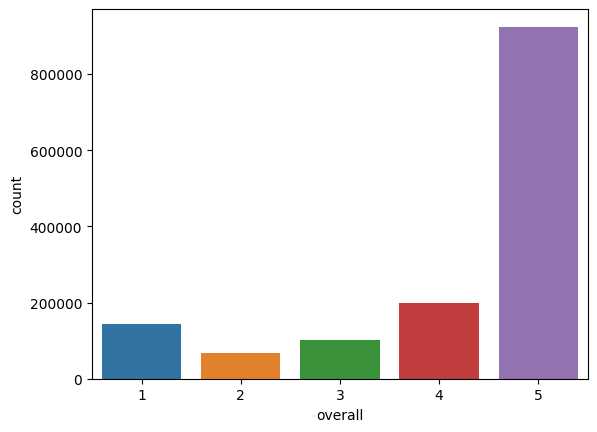

In [65]:
sns.countplot(df_all, x="overall")

In [12]:
df_all['overall'].value_counts()/len(df_all)

5    0.643370
4    0.138638
1    0.099485
3    0.070866
2    0.047641
Name: overall, dtype: float64

### Distribution of ratings for different product categories

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


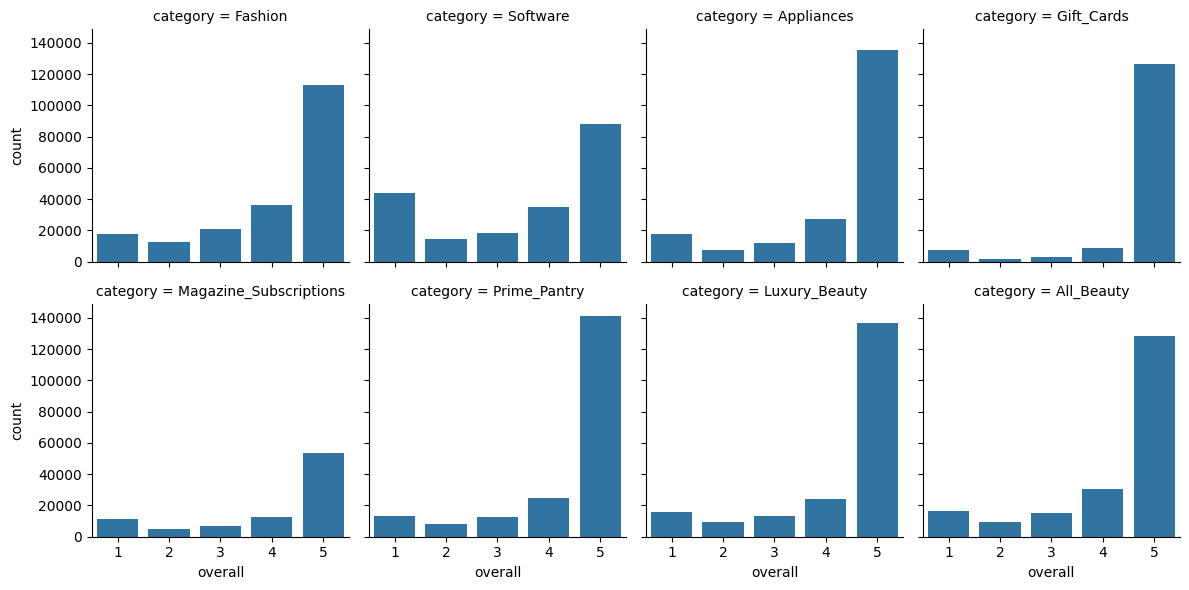

In [13]:
g = sns.FacetGrid(df_all, col="category", col_wrap=4)
g.map(sns.countplot, "overall")

### Common words/phrases in each review category

The following word clouds show the most frequent words used in reviews with rating 5 (excellent), 3 (neutral) and 1 (bad) for the eight product categories. We can see that words like "love", "best", "nice", "great", etc are common in positive reviews, words like "okay", "like" are common in average reviews, and words like "poor", "dissappointed", "waste", "missing" can be commonly seen in the negative reviews.

As expected, the words in each category also represent the products in that category: for example, in the Gift Card category, the words "card" and "gift" are the two most common words, in Luxuary Beauty category, the words "lotion" and "skin" are among the most common words, etc.

In [30]:
def word_cloud(data, ax, category):
    """Create a wordcloud of text data
              Parameters
              ----------
              data : dataframe
                  Dataframe containing the review text
              ax  : axis
                  Plot axis
              category: str
                  category of the product review (e.g. "software")
              """
    wordcloud = WordCloud(
    background_color = "white",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords.words("english"),
    scale = 3).generate(str(data["reviewText"]))
    ax.axis("off")
    ax.imshow(wordcloud)
    ax.set_title(category, fontsize=30)

#### Positive reviews

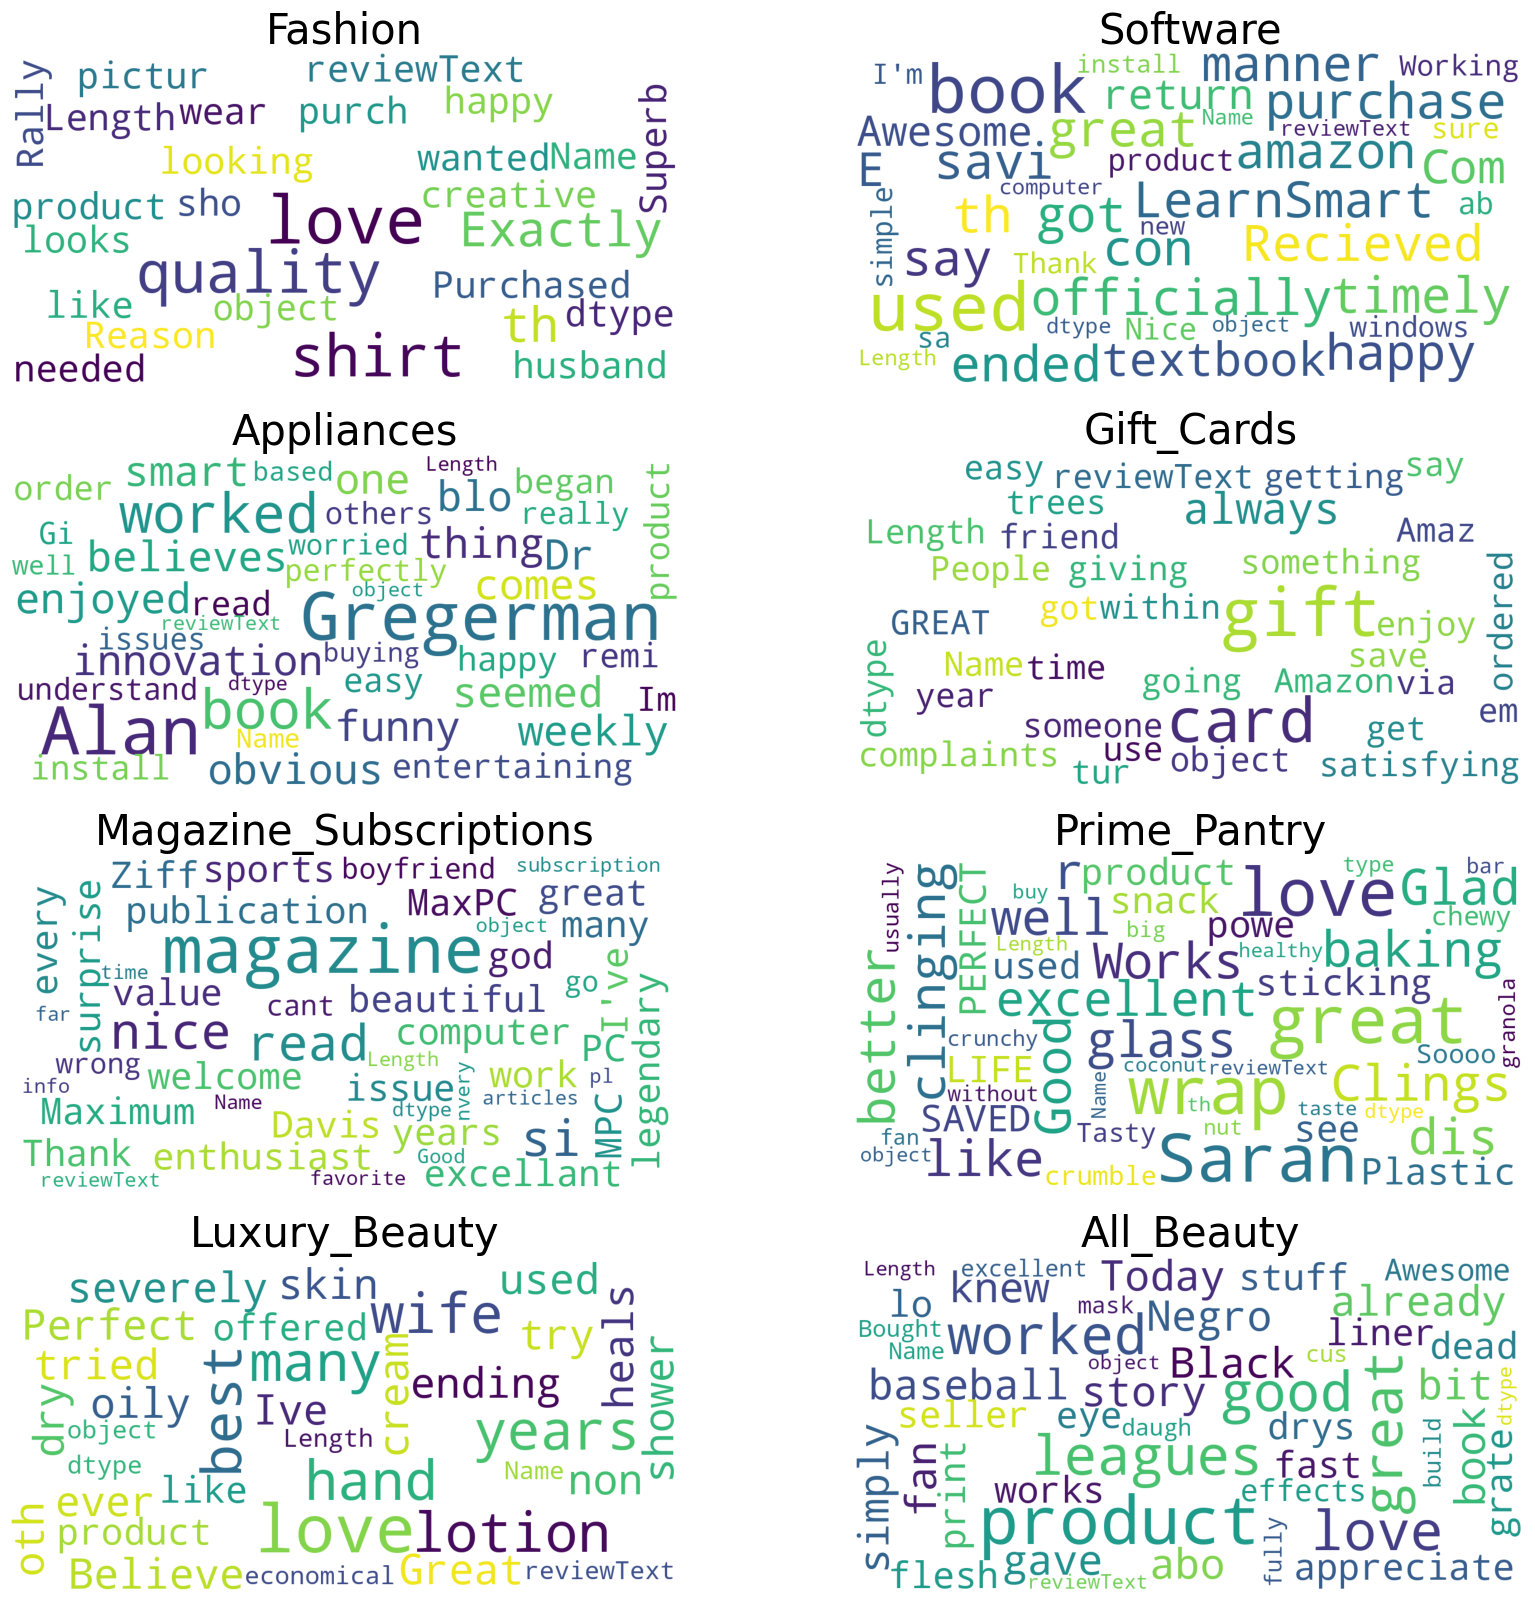

In [35]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(categories, ax.flatten()):
    word_cloud(df_all[(df_all['category']==variable) & (df_all['overall']==5)], ax=subplot, category=variable)
plt.savefig('positive_reviews_wordcloud.pdf')

#### Average (neutral) reviews

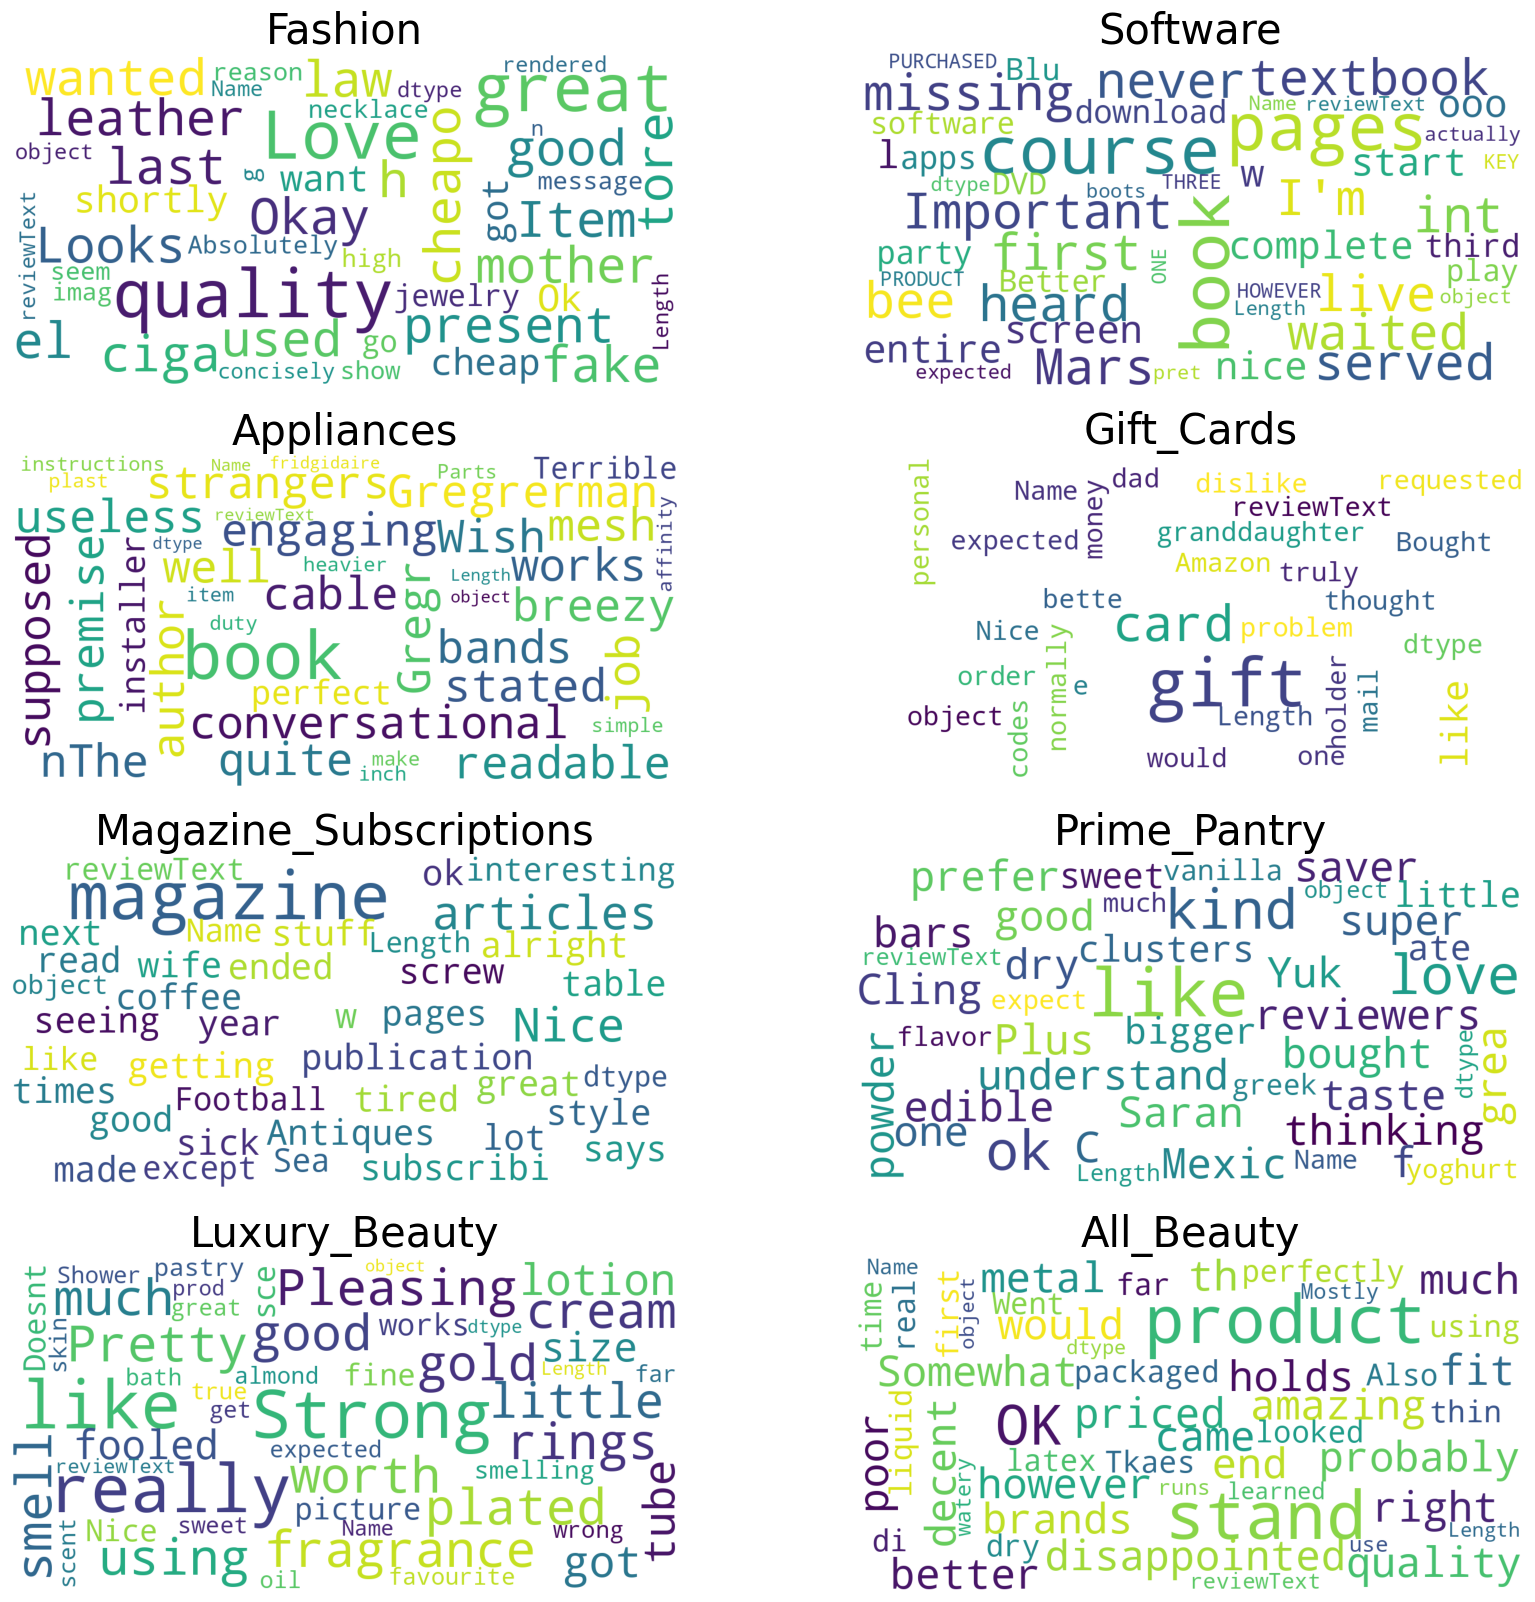

In [36]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(categories, ax.flatten()):
    word_cloud(df_all[(df_all['category']==variable) & (df_all['overall']==3)], ax=subplot, category=variable)
plt.savefig('average_reviews_wordcloud.pdf')

#### Negative reviews

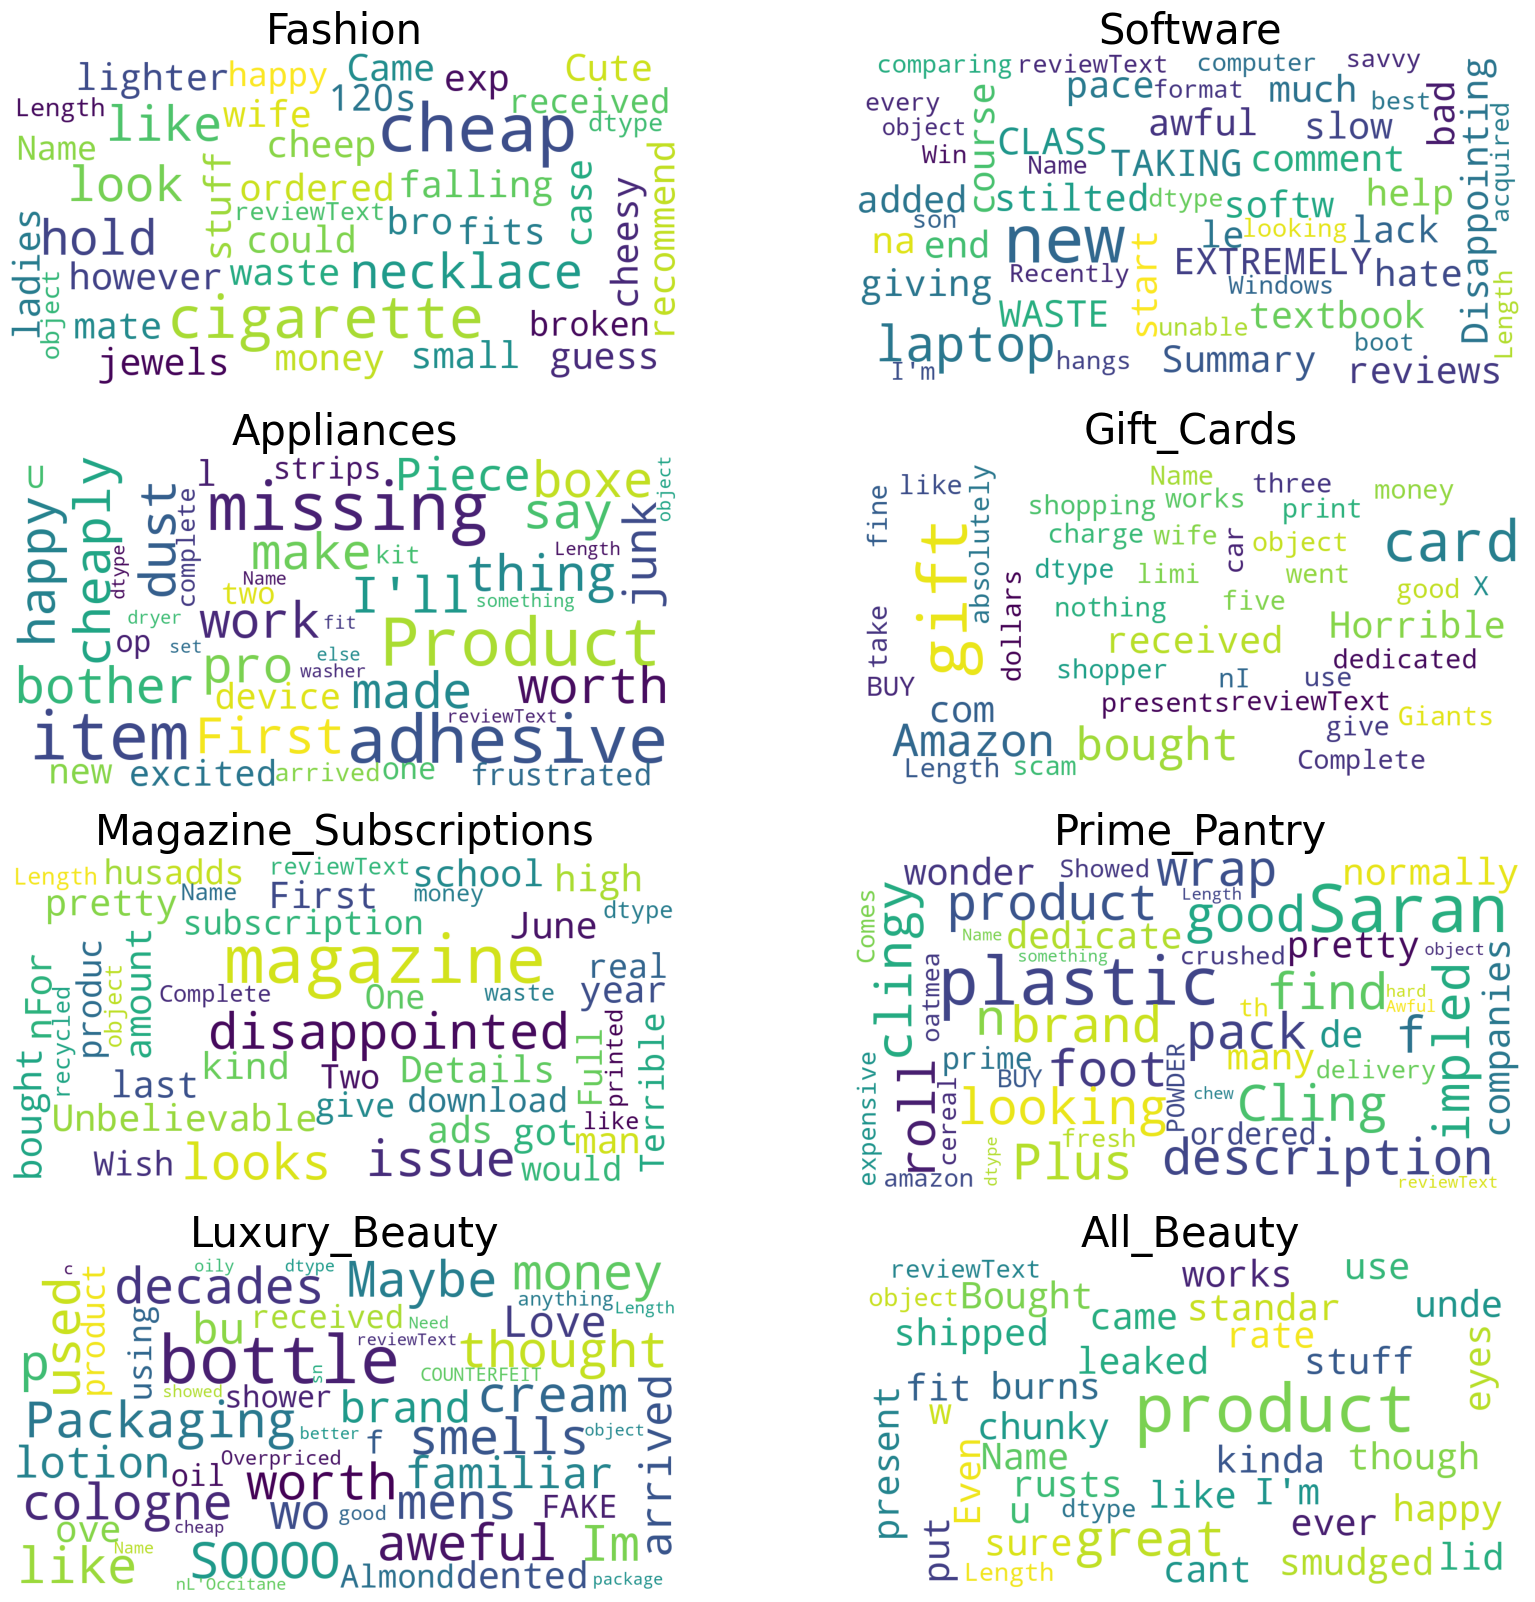

In [37]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for variable, subplot in zip(categories, ax.flatten()):
    word_cloud(df_all[(df_all['category']==variable) & (df_all['overall']==1)], ax=subplot, category=variable)
plt.savefig('negative_reviews_wordcloud.pdf')

#### Common phrases

In [13]:
def get_top_n_bigram(data, n=None):
    """find the top bigrams in a collection of text data
                  Parameters
                  ----------
                  data : dataframe
                      Dataframe containing the review text
                  n  : int
                      Number of returned bigrams
                  Returns
                  -------
                  list
                      top n bigrams in data
                  """
    vec = CountVectorizer(ngram_range=(2, 2),stop_words='english').fit(data.values.astype('U'))
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def n_gram_plot(data, title, color):
    """Plots the top n bigrams in data (output of get_top_n_bigram)
              Parameters
              ----------
              data : list
                  the list of bigrams to be plotted
              title  : str
                  title of the plot
              color: str
                  specifies the color of the plot
              """
    x=[x[0] for x in data]
    y=[x[1] for x in data]
    sns.barplot(y=x,x=y,color='{}'.format(color))
    plt.title('{} reviews'.format(title),fontsize=15)
    plt.yticks(rotation=0,fontsize=15)

The figure below shows the common phrases (bigrams) in the reviews with rating 5, 3 or 1. Common phrases in reviews with excellent ratings were "good quality", "great product", "fit perfectly", etc, that are expected. Common phrases in negative reviews are "waste money", "customer service", "tech support", "doesn work" which suggests that the product had some problems or the customer needed technical help with it. The average reviews are more mixed, with some positive (e.g., "user friendly") and some negative phrases (e.g., "don know", "don like").

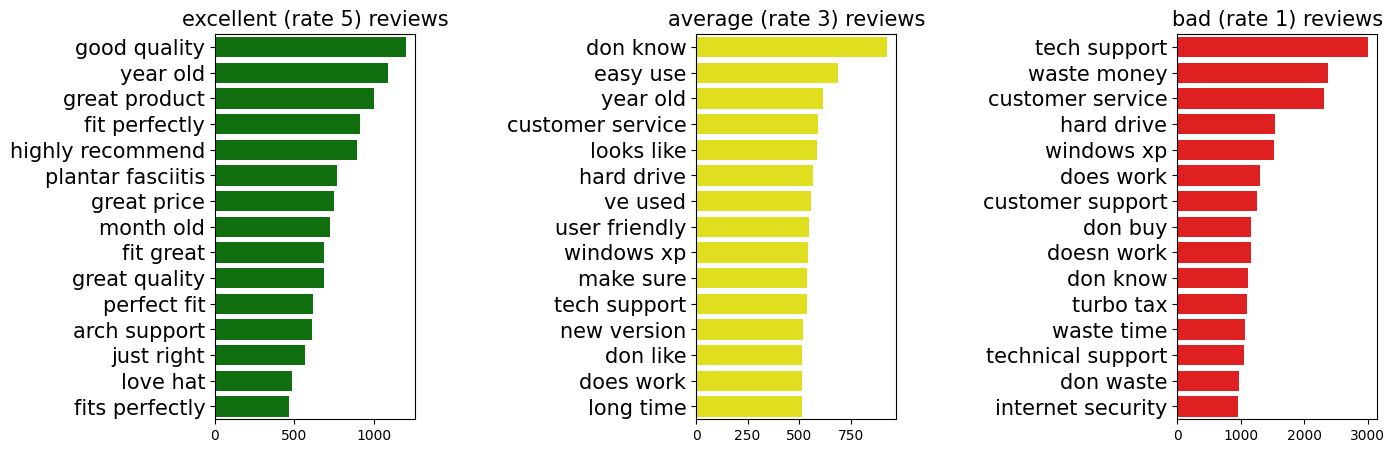

In [43]:
common_words_5 = get_top_n_bigram(df_all[df_all['overall']==5]['reviewText'][:50000], 15)
common_words_3 = get_top_n_bigram(df_all[df_all['overall']==3]['reviewText'][:50000], 15)
common_words_1 = get_top_n_bigram(df_all[df_all['overall']==1]['reviewText'][:50000], 15)

plt.figure(figsize=(15,5))
plt.subplot(151)
n_gram_plot(common_words_5,'excellent (rate 5)','green')
plt.subplot(153)
n_gram_plot(common_words_3,'average (rate 3)','yellow')
plt.subplot(155)
n_gram_plot(common_words_1,'bad (rate 1)','red')

plt.savefig('phrases.pdf')

The common phrases in a specific product category like "Fashion" gives similar results, but the phrases are more context-depenedant: e.g., many of the phrases in the 'Fashion' category discuss size and quality of fit ("fits perfectly", "runs small", "way big", "ordered size").  

['Fashion', 'Software', 'Appliances', 'Gift_Cards', 'Magazine_Subscriptions']


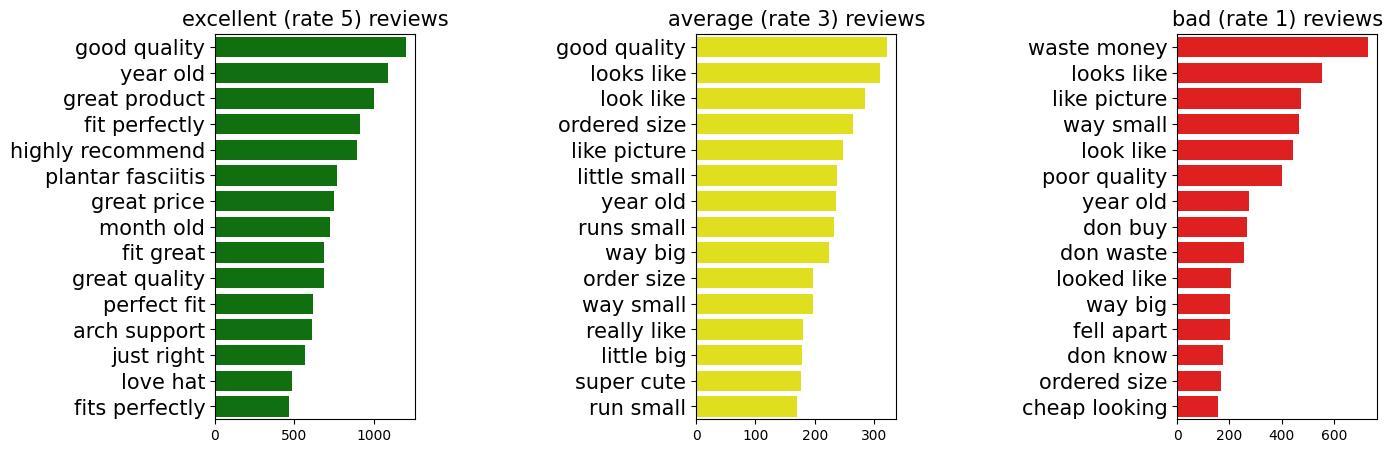

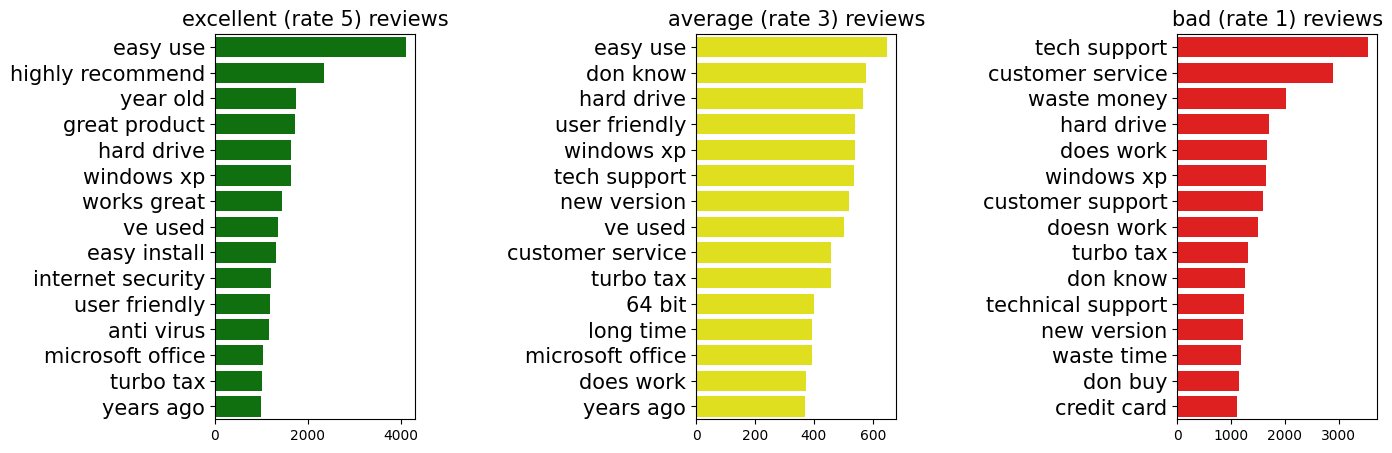

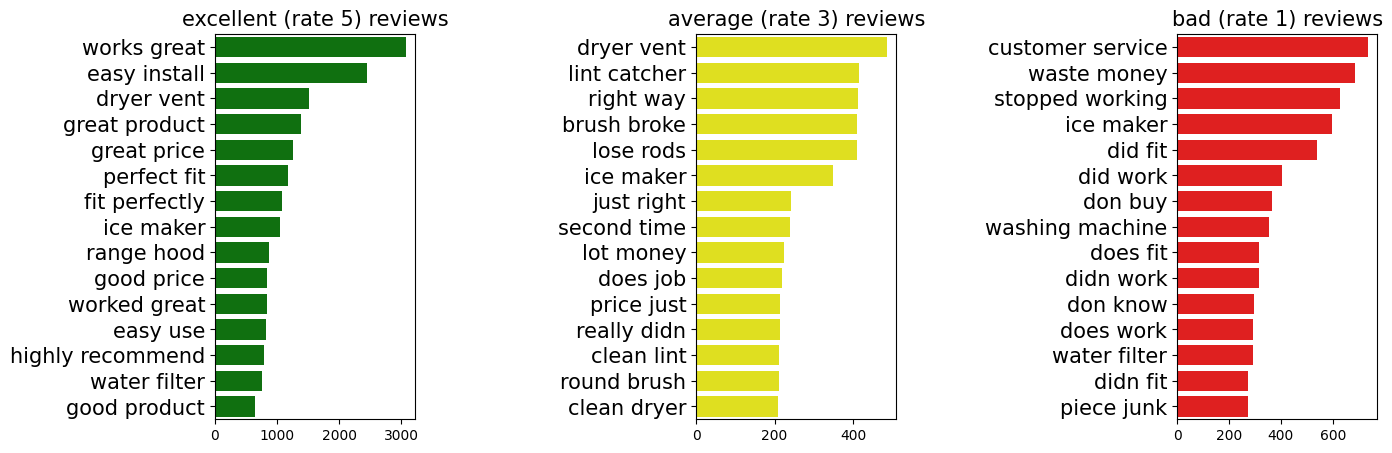

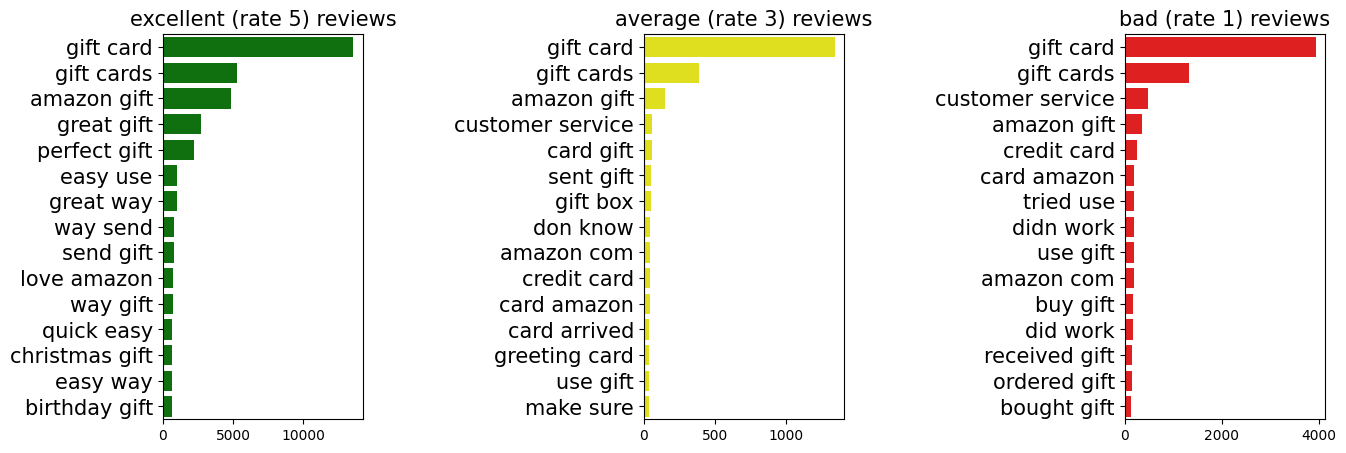

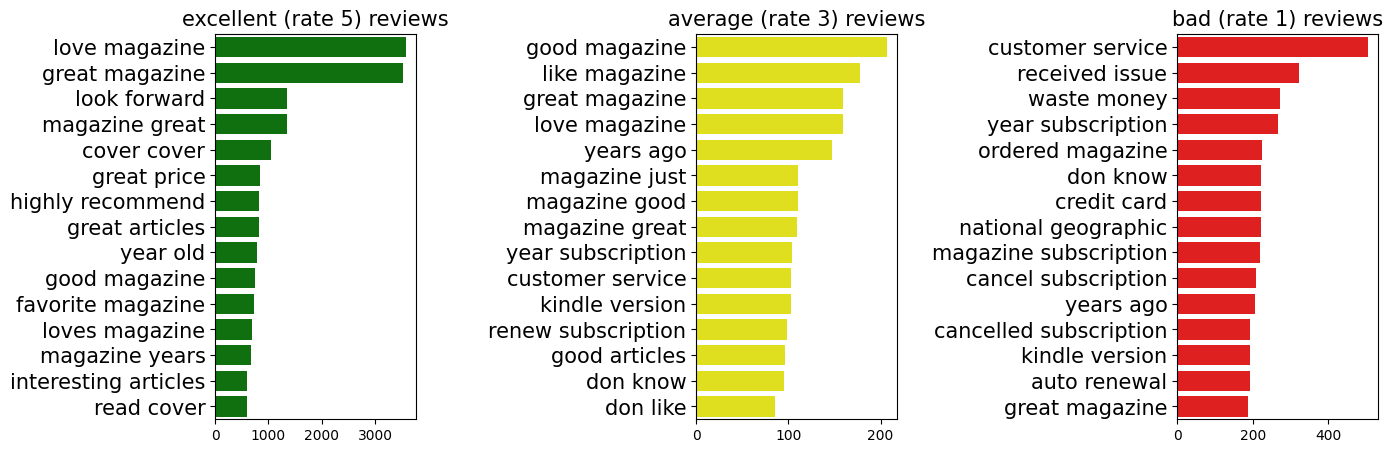

In [14]:
print(categories[:5])
for c in categories[:5]:
  common_words_5 = get_top_n_bigram(df_all[(df_all['category']==c) & (df_all['overall']==5)]['reviewText'][:50000], 15)
  common_words_3 = get_top_n_bigram(df_all[(df_all['category']==c) & (df_all['overall']==3)]['reviewText'][:50000], 15)
  common_words_1 = get_top_n_bigram(df_all[(df_all['category']==c) & (df_all['overall']==1)]['reviewText'][:50000], 15)

  plt.figure(figsize=(15,5))
  plt.subplot(151)
  n_gram_plot(common_words_5,'excellent (rate 5)','green')
  plt.subplot(153)
  n_gram_plot(common_words_3,'average (rate 3)','yellow')
  plt.subplot(155)
  n_gram_plot(common_words_1,'bad (rate 1)','red')

plt.savefig('phrases_all.pdf')

### Correlation between review length/word count and sentiment of a review

As the following code snippet shows, the Pearson correlation between the rating of a review and its word_count is -0.171628 and the correlation between the rating and the review length is -0.169229, both of which are negative. This suggests that negative reviews tend to have longer length and higher word count compared to positive reviews.

In [58]:
df_all[['overall', 'word_count', 'review_len']].corr(numeric_only=False)

overall  word_count  review_len
overall     1.000000   -0.171628   -0.169229
word_count -0.171628    1.000000    0.996315
review_len -0.169229    0.996315    1.000000

## Sentiment Analysis

In the following section, we train different classifiers for sentiment analysis on the Amazon review data and compare them on test data.

In [105]:
# shuffling the rows of the dataframe to sample from all product categories
df_shuffle = df_all.sample(frac = 1)

Due to resource limitations, we sample 50K of the reviews and use 80% for training and 20% for testing.

In [106]:
df_select = df_shuffle[:50000]
msk = np.random.rand(len(df_select)) < 0.8
df_train = df_select[msk]
df_test = df_select[~msk]
X_train = df_train["reviewText"]
Y_train = df_train["overall"]
X_test = df_test["reviewText"]
Y_test = df_test["overall"]

In [107]:
print("# training samples:", len(X_train))

# training samples: 40051


In [108]:
print("# test samples:", len(X_test))

# test samples: 9949


For feature vector representation, we use both TF-IDF vectorizer and count vectorizer. For feature selection, we choose the best 2000 features using chi-squared test with scikit-learn's SelectKBest function. For classifiers, we try variants of Naive Bayes, Random Forest and SGD. In total, we try 10 classifiers and pick the one with the best performance.  The highest accuracy on this portion of the data was for SGD classifier with count vectorizer. However, for our software, we trained the classifier on a larger portion of the data (100K).

In [134]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, sublinear_tf=True, norm='l2', ngram_range=(1,1))
count_vectorizer = CountVectorizer(ngram_range=(1,1))
vectorizers = [tfidf_vectorizer, count_vectorizer]
feature_selection = SelectKBest(chi2, k=1200)
classifiers = [RandomForestClassifier(), MultinomialNB(), ComplementNB(), BernoulliNB(), SGDClassifier()]

In [110]:
def create_classifier(vector_representation, feature_selection, classifier):
    """Takes elements of a classifier as input and creates a pipeline containing them
                      Parameters
                      ----------
                      vector_representation : sklearn.feature_extraction.text object
                          Count vectorizer or TF-IDF vectorizer
                      feature_selection:
                          sklearn.feature_selection object
                      classifier:
                          classifier object
                      Returns
                      -------
                      an sklearn.pipeline object containing vector_representation,
                      feature_selection and the classifier objects
                      """
    return Pipeline([('vect', vector_representation), ('chi', feature_selection), ('clf', classifier)])

In [154]:
def predict(clf, review, clean=False):
    """Takes a classifier and a review as input and predicts its sentiment
                  Parameters
                  ----------
                  clf : classifier object
                      Sentiment analysis classifier
                  review: str
                      Review text object
                  clean: bool
                      clean the text before predicting its review if True
                  Returns
                  -------
                  rating: int
                      an integer between 1 to 5 which shows the predicted sentiment of the review
                  prob_rating: list
                      a probability distribution over the 5 ratings
                  """
    if clean:
        review = clean_text(review)
    prediction_df = pd.DataFrame([[review,0]],columns=["reviewText", "y"])
    rating = clf.predict(prediction_df["reviewText"])[0]
    try:
      prob_rating = clf.predict_proba(prediction_df["reviewText"])[0]
    except:
      prob_rating = None
    return rating, prob_rating

In [113]:
def run_model(clf, model_name):
  print(model_name)
  print(clf)
  trained_clf = clf.fit(X_train, Y_train)
  print('Testing accuracy:', np.mean(trained_clf.predict(X_test)== Y_test))
  return trained_clf

In [114]:
RF_cv = create_classifier(count_vectorizer, feature_selection, RandomForestClassifier())
RF_cv = run_model(RF_cv, "Random Forest Classifier - Count Vectorizer:")

Random Forest Classifier - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', RandomForestClassifier())])
Testing accuracy: 0.6797668107347472


In [122]:
s = pickle.dumps(RF_cv)

with open('models/RF_cv_clf.pkl', 'wb') as f:
    pickle.dump(RF_cv, f)

with open('models/RF_cv_clf.pkl', 'rb') as f:
    RF_cv = pickle.load(f)

In [123]:
RF_tfidf = create_classifier(tfidf_vectorizer, feature_selection, RandomForestClassifier())
RF_tfidf = run_model(RF_tfidf, "Random Forest Classifier - TF-IDF Vectorizer:")

Random Forest Classifier - TF-IDF Vectorizer:
Pipeline(steps=[('vect', TfidfVectorizer(min_df=3, sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', RandomForestClassifier())])
Testing accuracy: 0.6833852648507388


In [124]:
s = pickle.dumps(RF_tfidf)

with open('models/RF_tfidf_clf.pkl', 'wb') as f:
    pickle.dump(RF_tfidf, f)

with open('models/RF_tfidf_clf.pkl', 'rb') as f:
    RF_tfidf = pickle.load(f)

In [135]:
MultinomialNB_cv = create_classifier(count_vectorizer, feature_selection, MultinomialNB())
MultinomialNB_cv = run_model(MultinomialNB_cv, "Multinomial Naive Bayes - Count Vectorizer:")

Multinomial Naive Bayes - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', MultinomialNB())])
Testing accuracy: 0.6804703990350789


In [136]:
s = pickle.dumps(MultinomialNB_cv)

with open('models/MultinomialNB_cv_clf.pkl', 'wb') as f:
    pickle.dump(MultinomialNB_cv, f)

with open('models/MultinomialNB_cv_clf.pkl', 'rb') as f:
    MultinomialNB_cv = pickle.load(f)

In [137]:
MultinomialNB_tfidf = create_classifier(tfidf_vectorizer, feature_selection, MultinomialNB())
MultinomialNB_tfidf = run_model(MultinomialNB_tfidf, "Multinomial Naive Bayes - TF-IDF Vectorizer:")

Multinomial Naive Bayes - TF-IDF Vectorizer:
Pipeline(steps=[('vect', TfidfVectorizer(min_df=3, sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', MultinomialNB())])
Testing accuracy: 0.6674037591717761


In [138]:
s = pickle.dumps(MultinomialNB_tfidf)

with open('models/MultinomialNB_tfidf_clf.pkl', 'wb') as f:
    pickle.dump(MultinomialNB_tfidf, f)

with open('models/MultinomialNB_tfidf_clf.pkl', 'rb') as f:
    MultinomialNB_tfidf = pickle.load(f)

In [139]:
ComplementNB_cv = create_classifier(count_vectorizer, feature_selection, ComplementNB())
ComplementNB_cv = run_model(ComplementNB_cv, "Complement Naive Bayes - Count Vectorizer:")

Complement Naive Bayes - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', ComplementNB())])
Testing accuracy: 0.6628806915267866


In [140]:
s = pickle.dumps(ComplementNB_cv)

with open('models/ComplementNB_cv_clf.pkl', 'wb') as f:
    pickle.dump(ComplementNB_cv, f)

with open('models/ComplementNB_cv_clf.pkl', 'rb') as f:
    ComplementNB_cv = pickle.load(f)

In [141]:
ComplementNB_tfidf = create_classifier(tfidf_vectorizer, feature_selection, ComplementNB())
ComplementNB_tfidf = run_model(ComplementNB_tfidf, "Complement Naive Bayes - TF-IDF Vectorizer:")

Complement Naive Bayes - TF-IDF Vectorizer:
Pipeline(steps=[('vect', TfidfVectorizer(min_df=3, sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', ComplementNB())])
Testing accuracy: 0.6260930746808725


In [143]:
s = pickle.dumps(ComplementNB_tfidf)

with open('models/ComplementNB_tfidf_clf.pkl', 'wb') as f:
    pickle.dump(ComplementNB_tfidf, f)

with open('models/ComplementNB_tfidf_clf.pkl', 'rb') as f:
    ComplementNB_tfidf = pickle.load(f)

In [144]:
BernoulliNB_cv = create_classifier(count_vectorizer, feature_selection, BernoulliNB())
BernoulliNB_cv = run_model(BernoulliNB_cv, "Bernoulli Naive Bayes - Count Vectorizer:")

Bernoulli Naive Bayes - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', BernoulliNB())])
Testing accuracy: 0.5966428786812745


In [146]:
s = pickle.dumps(BernoulliNB_cv)

with open('models/BernoulliNB_cv_clf.pkl', 'wb') as f:
    pickle.dump(BernoulliNB_cv, f)

with open('models/BernoulliNB_cv_clf.pkl', 'rb') as f:
    BernoulliNB_cv = pickle.load(f)

In [145]:
BernoulliNB_tfidf = create_classifier(tfidf_vectorizer, feature_selection, BernoulliNB())
BernoulliNB_tfidf = run_model(BernoulliNB_tfidf, "Bernoulli Naive Bayes - TF-IDF Vectorizer:")

Bernoulli Naive Bayes - TF-IDF Vectorizer:
Pipeline(steps=[('vect', TfidfVectorizer(min_df=3, sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', BernoulliNB())])
Testing accuracy: 0.6066941401145843


In [147]:
s = pickle.dumps(BernoulliNB_tfidf)

with open('models/BernoulliNB_tfidf_clf.pkl', 'wb') as f:
    pickle.dump(BernoulliNB_tfidf, f)

with open('models/BernoulliNB_tfidf_clf.pkl', 'rb') as f:
    BernoulliNB_tfidf = pickle.load(f)

In [148]:
SGDClassifier_cv = create_classifier(count_vectorizer, feature_selection, SGDClassifier())
SGDClassifier_cv = run_model(SGDClassifier_cv, "SGD Classifier - Count Vectorizer:")

SGD Classifier - Count Vectorizer:
Pipeline(steps=[('vect', CountVectorizer()),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', SGDClassifier())])
Testing accuracy: 0.6949442154990452


In [149]:
s = pickle.dumps(SGDClassifier_cv)

with open('models/SGDClassifier_cv_clf.pkl', 'wb') as f:
    pickle.dump(SGDClassifier_cv, f)

with open('models/SGDClassifier_cv_clf.pkl', 'rb') as f:
    SGDClassifier_cv = pickle.load(f)

In [150]:
SGDClassifier_tfidf = create_classifier(tfidf_vectorizer, feature_selection, SGDClassifier())
SGDClassifier_tfidf = run_model(SGDClassifier_tfidf, "SGD Classifier - TF-IDF Vectorizer:")

SGD Classifier - TF-IDF Vectorizer:
Pipeline(steps=[('vect', TfidfVectorizer(min_df=3, sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1200,
                             score_func=<function chi2 at 0x7eb307df2c20>)),
                ('clf', SGDClassifier())])
Testing accuracy: 0.6925319127550508


In [151]:
s = pickle.dumps(SGDClassifier_tfidf)

with open('models/SGDClassifier_tfidf_clf.pkl', 'wb') as f:
    pickle.dump(SGDClassifier_tfidf, f)

with open('models/SGDClassifier_tfidf_clf.pkl', 'rb') as f:
    SGDClassifier_tfidf = pickle.load(f)

### Example predictions

The examples below show the result of running the two Random Forest-based classifiers on three reviews:

In [117]:
predict(RF_cv, "works good, viewing angle critical for good picture. purchased for use in a rv so the size was perfect for the location")

(5, array([0.02      , 0.02      , 0.06      , 0.11333333, 0.78666667]))

In [118]:
predict(RF_cv, "These little plastic backs work great.  No more loosing 'hook' earrings!  Wish I had ordered these sooner before I had lost some of my favorite earrings!")

(4, array([0.03 , 0.   , 0.01 , 0.682, 0.278]))

In [153]:
predict(RF_tfidf, 'this looks really bad')

(1, array([0.69, 0.  , 0.02, 0.05, 0.24]))